<a href="https://colab.research.google.com/github/J0KERtry/python_repository/blob/main/p%E3%83%81%E3%83%BC%E3%83%A0(%E4%BF%AE%E6%AD%A3%E7%89%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 環境の構築

In [ ]:
# 環境の準備 
!pip install -q japanize_matplotlib

     |████████████████████████████████| 4.1 MB 4.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import japanize_matplotlib
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')
%matplotlib inline
%precision 3
plt.rcParams['figure.figsize'] = 10, 7

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/exercise.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


##データの全体像

### まずはデータ全体を確認

In [ ]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
# 定性的なデータの確認（代表値の確認）
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
recency,64000,NaN,NaN,NaN,5.76373,3.50759,1,2,6,9,12
history,64000,NaN,NaN,NaN,242.086,256.159,29.99,64.66,158.11,325.657,3345.93
used_discount,64000,NaN,NaN,NaN,0.551031,0.497393,0,0,1,1,1
used_bogo,64000,NaN,NaN,NaN,0.549719,0.497526,0,0,1,1,1
zip_code,64000,3,Surburban,28776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_referral,64000,NaN,NaN,NaN,0.50225,0.499999,0,0,1,1,1
channel,64000,3,Web,28217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offer,64000,3,Buy One Get One,21387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conversion,64000,NaN,NaN,NaN,0.146781,0.35389,0,0,0,0,1


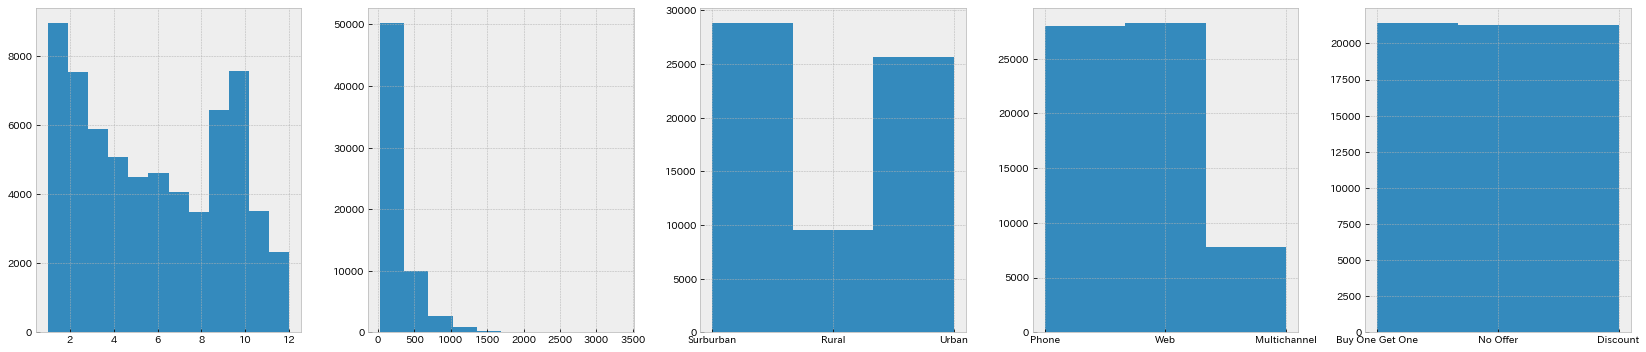

In [ ]:
plt.rcParams['figure.figsize'] = 23, 5
plt.subplot(1, 5, 1)
df['recency'].hist(bins=12);

plt.subplot(1, 5, 2)
df['history'].hist();

plt.subplot(1, 5, 3)
df['zip_code'].hist(bins=3);

plt.subplot(1, 5, 4)
df['channel'].hist(bins=3);

plt.subplot(1, 5, 5)
df['offer'].hist(bins=3);

plt.tight_layout()

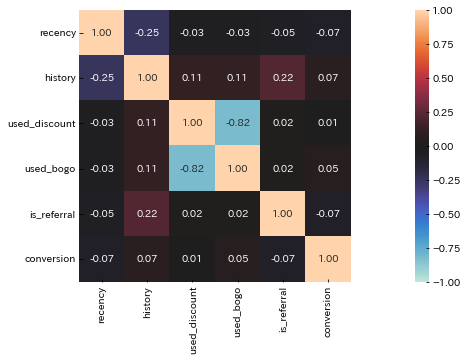

In [ ]:
# 相関分析
sns.heatmap(df.corr(), annot=True, square=True, vmax=1, vmin=-1, center=0, fmt='.2f');

In [ ]:
#数値化
_df = pd.get_dummies(df, drop_first=True)  
_df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.449625,0.400953,0.437828,0.440891,0.332922,0.332906
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.497460,0.490095,0.496123,0.496498,0.471263,0.471257
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# _dfからzip_code_Surburbanを削除
_df = _df.drop('zip_code_Surburban', axis=1)

# zip_code_Ruralを追加
tmp_df = pd.get_dummies(df)
_df['zip_code_Rural'] = tmp_df['zip_code_Rural']
_df.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
0,10,142.44,1,0,0,0,0,1,0,0,0,0
1,6,329.08,1,1,1,0,0,0,1,0,1,1
2,7,180.65,0,1,1,0,0,0,1,0,0,0
3,9,675.83,1,0,1,0,0,0,1,1,0,1
4,2,45.34,1,0,0,0,1,0,1,0,0,0


### 全顧客でクラスタリング

In [ ]:
# データの分割
x = _df.drop('conversion', axis=1)
y = _df['conversion']

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# DataFrame に格納
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
x_scaled.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
0,1.207751,-0.389003,0.902651,-1.104914,-1.00451,-0.818119,1.133138,-0.888008,-0.706452,-0.706427,-0.419131
1,0.067359,0.339614,0.902651,0.905048,0.99551,-0.818119,-0.882505,1.126116,-0.706452,1.415574,2.385888
2,0.352457,-0.239836,-1.107848,0.905048,0.99551,-0.818119,-0.882505,1.126116,-0.706452,-0.706427,-0.419131


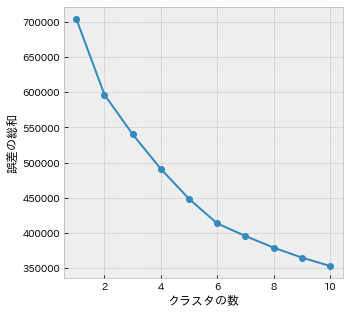

In [ ]:
# クラスタリング : エルボー法による最適なクラスタ数の計算  
from sklearn.cluster import KMeans
scaler = StandardScaler()

sse = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(x_scaled)             # クラスタリングの計算を実行
    sse.append(kmeans.inertia_)   # kmeans.fitするとkmeans.inertia_が得られる
plt.figure(figsize=(5, 5))
plt.plot(range(1,11), sse , marker='o')
plt.xlabel('クラスタの数') 
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
# クラスタリングの実行 : エルボー法よりクラスタ数を６に指定して実装   
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(x_scaled)
cluster_all = kmeans.labels_

df_clustering = x_scaled.copy() # x_scalesd のデータをコピー
# 変数名 `cluster` で df_clustering にクラスタリングの結果を追加
df_clustering['cluster'] = cluster_all

In [ ]:
# 変数 `cluster` 毎に groupby() でまとめる  
groups = df_clustering.groupby('cluster')
groups.size()

cluster
0     6386
1    13766
2     9224
3    13367
4    10615
5    10642
dtype: int64

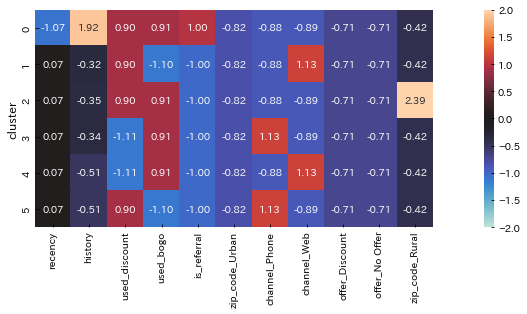

In [ ]:
# クラスタ毎の各項目の代表値を見る（中央値）
median = groups.median()
plt.figure(figsize=(18, 4))
sns.heatmap(median,annot=True,square=True,vmin=-2.0,vmax=2.0,center=0.0,fmt='.2f');

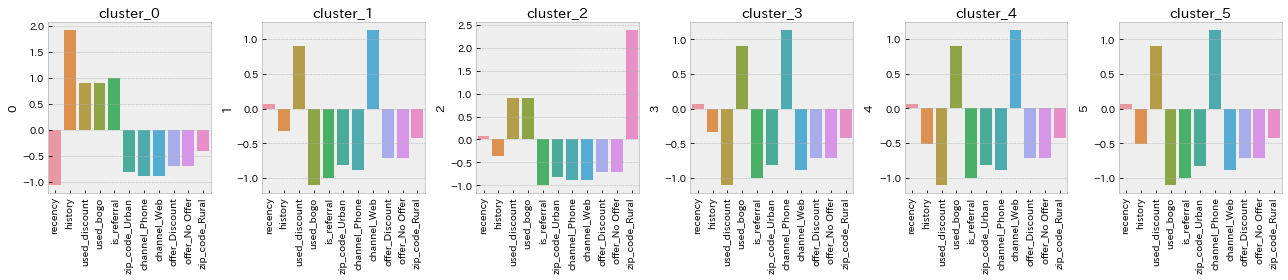

In [ ]:
# クラスターごとに可視化
num = kmeans.n_clusters
plt.figure(figsize=(18, 4))
for n in range(num):
    plt.subplot(1, num, n+1)
    plt.title(f'cluster_{n}')
    sns.barplot(x=median.columns, y=median.loc[n]) # colums：列名、mean.loc[n]：クラスタnの平均値
    plt.xticks(rotation = 90)
    plt.tight_layout()

### 全データで主成分分析

#### 実行

In [ ]:
# 主成分分析のクラス（PCA）のインスタンス化
from sklearn.decomposition import PCA
pca = PCA(random_state=0)

In [ ]:
# 主成分分析の実行
feature = pca.fit_transform(x_scaled)

In [ ]:
# DataFrameにfeatureを格納
pd.DataFrame(feature, columns=[f'PC{x+1}' for x in range(len(x.columns))]) 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-1.410456,-1.407213,0.050752,-1.447820,0.171398,0.068743,0.838021,-0.877634,0.987742,0.120111,0.072294
1,-0.022065,1.404108,-1.461159,0.618048,2.343666,0.773057,-0.056560,1.143615,-0.492121,0.142509,-1.226194
2,1.427413,1.412365,-0.051267,0.061204,0.263767,1.020654,-0.484127,-0.850477,0.994319,0.091940,0.067130
3,-1.398541,1.477039,1.567371,0.920884,2.296281,1.323533,1.090126,1.134184,-0.486108,0.563722,0.401116
4,-1.424549,1.404055,-0.052872,-0.370202,-1.216855,-1.446329,-0.688888,0.529260,1.016325,0.004344,-0.001346
...,...,...,...,...,...,...,...,...,...,...,...
63995,-1.396774,1.453449,1.452611,-1.381647,-1.353375,0.043195,0.708931,0.582486,-0.487968,0.085719,0.059600
63996,1.441695,-1.424434,1.485047,0.081896,-1.176952,0.581751,-1.155109,0.569278,-0.505213,-0.041848,-0.021923
63997,-1.399732,-1.424121,1.523712,-0.093799,-1.195124,0.778193,-1.015395,0.569612,-0.501934,-0.043810,-0.026111
63998,-1.422814,-0.018189,0.031939,2.126348,0.478711,-0.153866,-0.202675,-0.910950,0.992014,-0.948082,0.447784


#### 寄与率の確認

In [ ]:
# 寄与率
variance_ratio = pca.explained_variance_ratio_

pd.DataFrame(
    variance_ratio,
    index=[f'PC{x+1}' for x in range(len(variance_ratio))],
    columns=['寄与率']
)

,寄与率
PC1,0.165184
PC2,0.162194
PC3,0.136274
PC4,0.127668
PC5,0.122016
PC6,0.086231
PC7,0.065627
PC8,0.059710
PC9,0.045537
PC10,0.015735


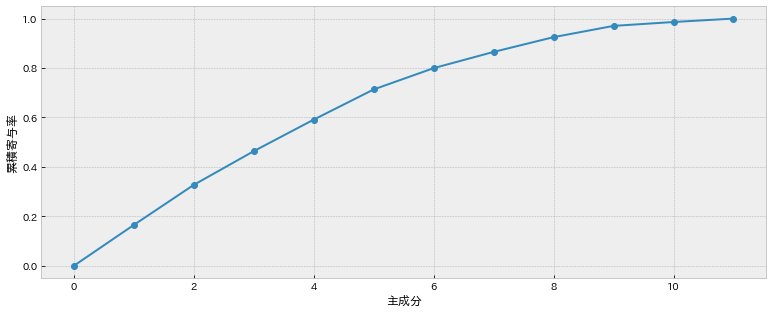

In [ ]:
# 寄与率を解釈する別の方法（図示）
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list(np.cumsum(variance_ratio,)), '-o')
plt.xlabel('主成分')
plt.ylabel('累積寄与率')
plt.show()

#### 主成分負荷量

In [ ]:
# 固有ベクトル
eigenvector = pca.components_

# DataFrameに格納
pd.DataFrame(eigenvector, index=[f'PC{x+1}' for x in range(len(eigenvector))], columns=x_scaled.columns)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
PC1,0.004144,0.000283,-0.707101,0.706965,0.000156,-0.001468,0.001236,0.000473,0.008604,-0.010515,-0.001612
PC2,0.003028,-0.000490,0.000346,0.000629,-0.013147,-0.014692,-0.706412,0.707053,0.020077,-0.013980,0.007794
PC3,0.001896,0.008613,0.010841,-0.008273,0.003136,-0.012990,0.016880,-0.017628,0.706481,-0.706638,0.022583
PC4,-0.511285,0.688550,0.086225,0.089210,0.467726,0.071009,-0.110824,-0.097203,-0.003360,0.002588,-0.059447
PC5,-0.049380,0.065217,0.006721,0.007630,0.039939,-0.703214,0.001876,-0.018625,-0.018483,0.018321,0.704324
PC6,0.658492,-0.015841,-0.005090,-0.009149,0.751717,-0.020282,0.005487,0.016506,-0.004067,0.000491,-0.014792
PC7,0.549409,0.659213,0.101601,0.098626,-0.461970,-0.001642,-0.117362,-0.127674,-0.004801,0.003370,-0.003279
PC8,0.022500,-0.003779,-0.001344,0.001747,0.013105,0.706828,-0.002114,0.005104,0.001318,0.010766,0.706788
PC9,-0.001689,0.000128,-0.001839,-0.003712,-0.001744,0.006084,-0.001599,0.004539,-0.707110,-0.707019,0.006059
PC10,0.010143,0.241874,-0.042608,-0.044395,-0.024657,0.000855,0.684875,0.684056,0.000659,0.002596,-0.002331


In [ ]:
np.sqrt(pca.explained_variance_).shape

(11,)

In [ ]:
# 主成分負荷量
factor_loading = pca.components_ * np.sqrt(pca.explained_variance_).reshape(11,1)

# DataFrameに格納
x_factor_loading = pd.DataFrame(factor_loading, index=[f'PC{x+1}' for x in range(len(factor_loading))], columns=x_scaled.columns)
x_factor_loading.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
PC1,0.005585,0.000382,-0.953159,0.952976,0.000210,-0.001979,0.001666,0.000637,0.011598,-0.014173,-0.002174
PC2,0.004045,-0.000655,0.000462,0.000840,-0.017561,-0.019624,-0.943571,0.944429,0.026817,-0.018674,0.010410
PC3,0.002321,0.010546,0.013274,-0.010129,0.003840,-0.015905,0.020667,-0.021583,0.864981,-0.865173,0.027650
PC4,-0.605904,0.815974,0.102182,0.105719,0.554284,0.084150,-0.131333,-0.115192,-0.003982,0.003067,-0.070449
PC5,-0.057209,0.075555,0.007786,0.008839,0.046270,-0.814696,0.002173,-0.021578,-0.021413,0.021225,0.815981


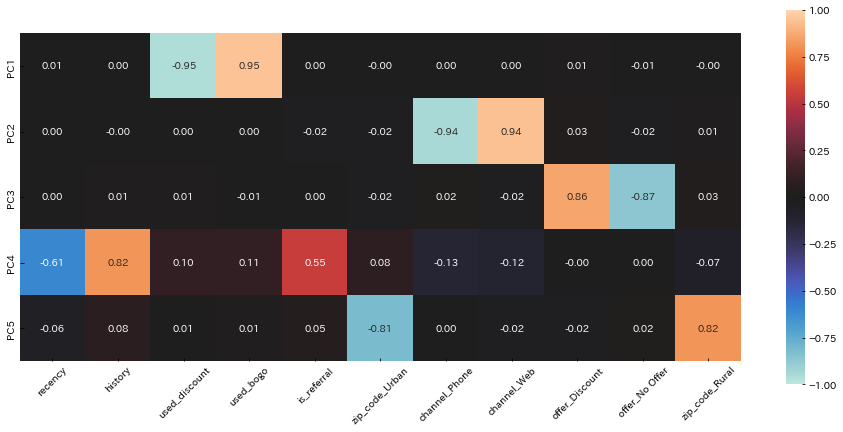

In [ ]:
# ヒートマップで可視化
sns.heatmap(x_factor_loading.head(5), vmax=1.0, center=0, vmin=-1.0, square=True, annot=True, fmt='.2f');
plt.rcParams['figure.figsize'] = 13, 5
plt.xticks(rotation=45);
plt.tight_layout()

#### クラスタリングの結果を踏まえて、第五主成分まで主成分分析の結果を可視化

In [ ]:
# 主成分分析のクラス（PCA）のインスタンス化
from sklearn.decomposition import PCA
pca = PCA(n_components=5, random_state=0) # n_components(生成する主成分の数)

In [ ]:
# 主成分分析の実行
feature_only5 = pca.fit_transform(x_scaled)
# DataFrameにfeatureを格納
feature_only5 = pd.DataFrame(feature_only5, columns=[f'PC{x+1}' for x in range(5)]) # リスト内包表記(for文の書き方の一つ)

new_data = pd.concat([df, feature_only5], axis=1)
new_data.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,PC1,PC2,PC3,PC4,PC5
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,-1.410456,-1.407213,0.050752,-1.447820,0.171398
1,6,329.08,1,1,Rural,1,Web,No Offer,0,-0.022065,1.404108,-1.461159,0.618048,2.343666
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,1.427413,1.412365,-0.051267,0.061204,0.263767
3,9,675.83,1,0,Rural,1,Web,Discount,0,-1.398541,1.477039,1.567371,0.920884,2.296281
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,-1.424549,1.404055,-0.052872,-0.370202,-1.216855


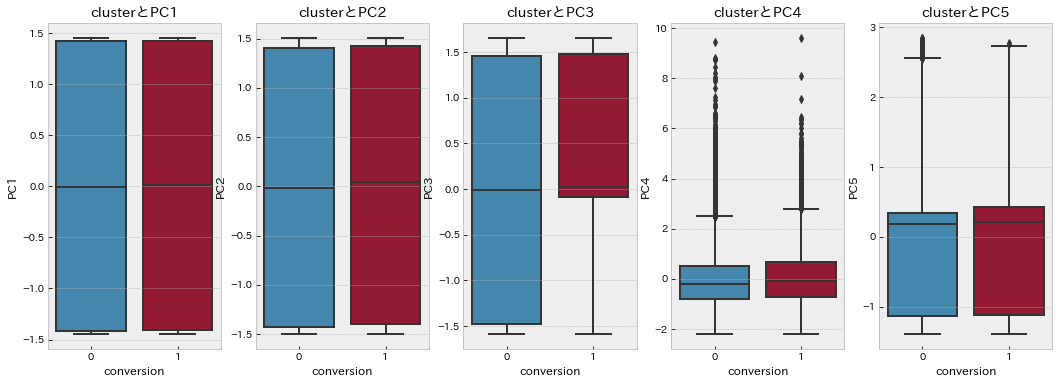

In [ ]:
plt.rcParams['figure.figsize'] = 18, 6
plt.subplot(1, 5, 1)
plt.title('clusterとPC1')
sns.boxplot(x='conversion', y='PC1', data=new_data);

plt.subplot(1, 5, 2)
plt.title('clusterとPC2')
sns.boxplot(x='conversion', y='PC2', data=new_data);

plt.subplot(1, 5, 3)
plt.title('clusterとPC3')
sns.boxplot(x='conversion', y='PC3', data=new_data);

plt.subplot(1, 5, 4)
plt.title('clusterとPC4')
sns.boxplot(x='conversion', y='PC4', data=new_data);

plt.subplot(1, 5, 5)
plt.title('clusterとPC5')
sns.boxplot(x='conversion', y='PC5', data=new_data);

考察
- オファーの獲得の有無はconversionの確度に関連しそう
- それ以外で、conversionの確度に直結しそうな特徴は見つけられず
- conversionの有無でデータを分けて中身を分析したら何かわかるかも

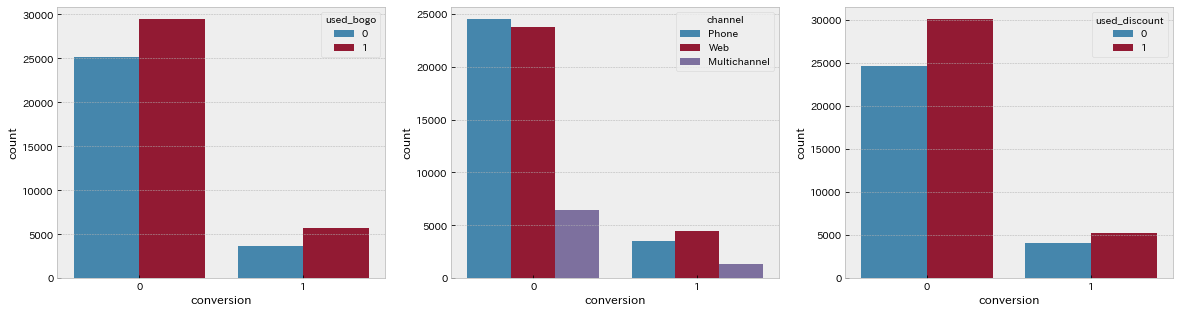

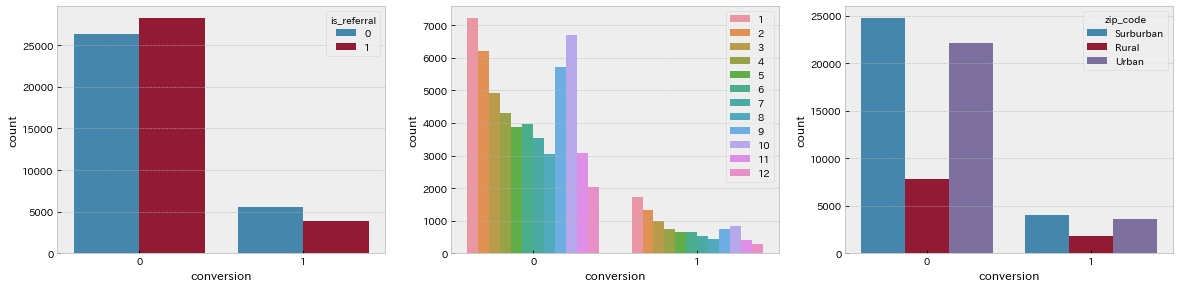

In [ ]:
plt.rcParams['figure.figsize'] = 20, 5
plt.subplot(1, 3, 1)
sns.countplot(x='conversion', hue='used_bogo', data=df);
# コンバージョン別のused_bogoの比較

plt.subplot(1, 3, 2)
sns.countplot(x='conversion', hue='channel', data=df);
# コンバージョン別のchannelの比較

plt.subplot(1, 3, 3)
sns.countplot(x='conversion', hue='used_discount', data=df);
# コンバージョン別のused_discountの比較

plt.show()

plt.rcParams['figure.figsize'] = 20, 10
plt.subplot(2, 3, 1)
sns.countplot(x='conversion', hue='is_referral', data=df);
# コンバージョン別のis_referralの比較

plt.subplot(2, 3, 2)
sns.countplot(x='conversion', hue='recency', data=df);
plt.legend(loc='upper right')
# コンバージョン別の購入月数の比較

plt.subplot(2, 3, 3)
sns.countplot(x='conversion', hue='zip_code', data=df);
# コンバージョン別のzip_codeの比較

plt.show()

### コンバージョンの有無でデータを分割して分析

#### CV=0

##### クラスタリング

In [ ]:
# 数値化
_df_not = pd.get_dummies(df.query('conversion == 0'), drop_first=True)

# データの分割
x_not = _df_not.drop('conversion', axis=1)
y_not = _df_not['conversion']

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_not_scaled = scaler.fit_transform(x_not)

# DataFrame に格納
x_not_scaled = pd.DataFrame(x_not_scaled, columns=x_not.columns)
x_not_scaled.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer
0,1.179102,-0.369340,0.905180,-1.081269,-1.035801,1.098359,-0.824326,1.110245,-0.876315,-0.684236,-0.731789
1,0.036422,0.374093,0.905180,0.924839,0.965436,-0.910449,-0.824326,-0.900702,1.141142,-0.684236,1.366514
2,0.322092,-0.217140,-1.104753,0.924839,0.965436,1.098359,-0.824326,-0.900702,1.141142,-0.684236,-0.731789
3,0.893432,1.755282,0.905180,-1.081269,0.965436,-0.910449,-0.824326,-0.900702,1.141142,1.461483,-0.731789
4,-1.106259,-0.756113,0.905180,-1.081269,-1.035801,-0.910449,1.213113,-0.900702,1.141142,-0.684236,-0.731789


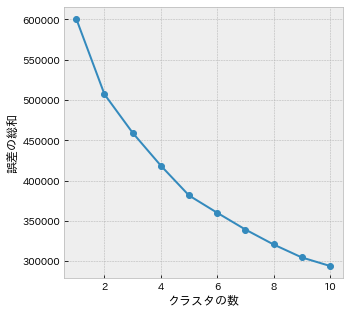

In [ ]:
# クラスタリング : エルボー法による最適なクラスタ数の計算  
from sklearn.cluster import KMeans
scaler = StandardScaler()

sse = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(x_not_scaled)             # クラスタリングの計算を実行
    sse.append(kmeans.inertia_)   # kmeans.fitするとkmeans.inertia_が得られる
plt.figure(figsize=(5, 5))
plt.plot(range(1,11), sse , marker='o')
plt.xlabel('クラスタの数') 
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
# クラスタリングの実行 : エルボー法でクラスタ数を5に指定   
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(x_not_scaled)
cluster = kmeans.labels_

In [ ]:
df_not_clustering = x_not_scaled.copy() # x_not_scaled のデータをコピー
# 変数名 `cluster` で df_not_clustering にクラスタリングの結果を追加
df_not_clustering['cluster'] = cluster

In [ ]:
# 変数 `cluster` 毎に groupby() でまとめる  
groups_not = df_not_clustering.groupby('cluster')
groups_not.size()

cluster
0     6061
1    13388
2    10532
3    11165
4    13460
dtype: int64

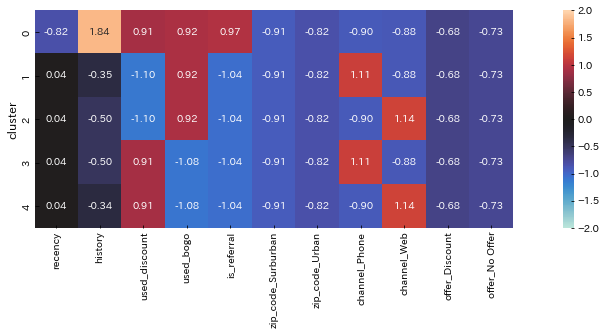

In [ ]:
# クラスタ毎の各項目の代表値を見る（中央値）：コンバージョンした場合
median_not = groups_not.median()
plt.figure(figsize=(18, 4))
sns.heatmap(median_not,annot=True,square=True,vmin=-2.0,vmax=2.0,center=0.0,fmt='.2f');

##### 主成分分析

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0)

# 主成分分析の実行
feature_not = pca.fit_transform(x_not_scaled)
# DataFrameにfeatureを格納
feature_not = pd.DataFrame(feature_not, columns=[f'PC{x+1}' for x in range(11)]) # リスト内包表記(for文の書き方の一つ)

new_data_not = pd.concat([df_not_clustering, feature_not], axis=1)
new_data_not.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,cluster,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,1.179102,-0.369340,0.905180,-1.081269,-1.035801,1.098359,-0.824326,1.110245,-0.876315,-0.684236,-0.731789,3,-1.416359,0.812785,-1.824235,-0.156538,-1.309193,-0.067371,0.852140,0.978830,-0.196213,0.115577,0.067686
1,0.036422,0.374093,0.905180,0.924839,0.965436,-0.910449,-0.824326,-0.900702,1.141142,-0.684236,1.366514,4,0.060751,-1.316687,0.519203,1.507147,0.723230,0.775643,-0.025987,-0.472883,1.219277,0.165507,-1.250612
2,0.322092,-0.217140,-1.104753,0.924839,0.965436,1.098359,-0.824326,-0.900702,1.141142,-0.684236,-0.731789,2,1.529429,-1.722374,-0.800117,-0.011375,0.121005,0.947990,-0.446785,1.026404,-0.188900,0.095809,0.066938


In [ ]:
# 寄与率の確認
variance_ratio = pca.explained_variance_ratio_ # 寄与率

pd.DataFrame(
    variance_ratio,
    index=[f'PC{x+1}' for x in range(len(variance_ratio))],
    columns=['寄与率']
)

,寄与率
PC1,0.167049
PC2,0.163132
PC3,0.158745
PC4,0.136446
PC5,0.125842
PC6,0.086645
PC7,0.066257
PC8,0.045374
PC9,0.022683
PC10,0.015314


#### CV=1

##### クラスタリング

In [ ]:
# 数値化
_df_buy = pd.get_dummies(df.query('conversion == 1'), drop_first=True)

# データの分割
x_buy = _df_buy.drop('conversion', axis=1)
y_buy = _df_buy['conversion']

# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_buy_scaled = scaler.fit_transform(x_buy)

# DataFrame に格納
x_buy_scaled = pd.DataFrame(x_buy_scaled, columns=x_buy.columns)
x_buy_scaled.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer
0,0.249474,-0.525526,-1.126049,0.796077,-0.839031,1.154450,-0.782577,1.279274,-0.958493,-0.841427,-0.563171
1,0.536709,0.949857,-1.126049,0.796077,1.191852,-0.866214,1.277829,1.279274,-0.958493,-0.841427,-0.563171
2,-0.899469,-0.643783,-1.126049,0.796077,-0.839031,-0.866214,1.277829,-0.781693,1.043304,1.188457,-0.563171
3,-0.612233,-0.798811,0.888061,-1.256159,1.191852,-0.866214,1.277829,-0.781693,1.043304,-0.841427,1.775658
4,-0.899469,-0.584067,0.888061,-1.256159,-0.839031,1.154450,-0.782577,-0.781693,1.043304,1.188457,-0.563171


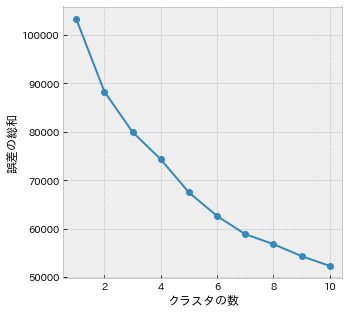

In [ ]:
# クラスタリング : エルボー法による最適なクラスタ数の計算  
from sklearn.cluster import KMeans
scaler = StandardScaler()

sse = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(x_buy_scaled)             # クラスタリングの計算を実行
    sse.append(kmeans.inertia_)   # kmeans.fitするとkmeans.inertia_が得られる
plt.figure(figsize=(5, 5))
plt.plot(range(1,11), sse , marker='o')
plt.xlabel('クラスタの数') 
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
# クラスタリングの実行 : エルボー法でクラスタ数を5に指定   
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(x_buy_scaled)
cluster = kmeans.labels_

In [ ]:
df_buy_clustering = x_buy_scaled.copy() # x_buy_scaled のデータをコピー
# 変数名 `cluster` で df_buy_clustering にクラスタリングの結果を追加
df_buy_clustering['cluster'] = cluster

In [ ]:
# 変数 `cluster` 毎に groupby() でまとめる  
groups_buy = df_buy_clustering.groupby('cluster')
groups_buy.size()

cluster
0    2664
1    1679
2    1872
3    1894
4    1285
dtype: int64

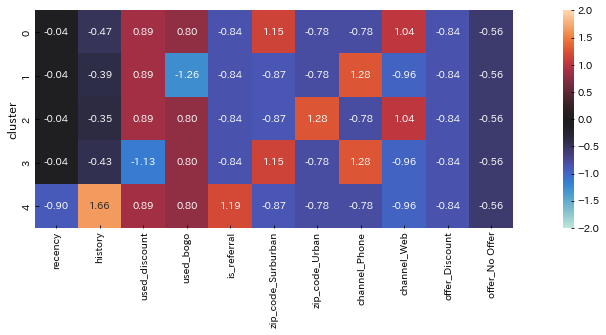

In [ ]:
# クラスタ毎の各項目の代表値を見る（中央値）：コンバージョンした場合
median_buy = groups_buy.median()
plt.figure(figsize=(18, 4))
sns.heatmap(median_buy,annot=True,square=True,vmin=-2.0,vmax=2.0,center=0.0,fmt='.2f');

##### 主成分分析

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0)

# 主成分分析の実行
feature_buy = pca.fit_transform(x_buy_scaled)
# DataFrameにfeatureを格納
feature_buy = pd.DataFrame(feature_buy, columns=[f'PC{x+1}' for x in range(11)]) # リスト内包表記(for文の書き方の一つ)

new_data_buy = pd.concat([df_buy_clustering, feature_buy], axis=1)
new_data_buy.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,cluster,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,0.249474,-0.525526,-1.126049,0.796077,-0.839031,1.154450,-0.782577,1.279274,-0.958493,-0.841427,-0.563171,3,1.859709,-1.343103,1.066656,-1.017370,0.277560,-0.213007,0.137666,0.909004,-0.209209,0.105655,0.109008
1,0.536709,0.949857,-1.126049,0.796077,1.191852,-0.866214,1.277829,1.279274,-0.958493,-0.841427,-0.563171,3,1.909271,-0.524958,-1.665968,1.014660,0.279129,1.229588,-0.240065,0.813882,-0.276540,0.488363,0.354152
2,-0.899469,-0.643783,-1.126049,0.796077,-0.839031,-0.866214,1.277829,-0.781693,1.043304,1.188457,-0.563171,2,-0.889570,-1.364147,-1.788885,-0.104911,-1.154043,-1.476273,-0.026772,-0.433762,-0.275927,0.020945,0.038805


In [ ]:
# 寄与率の確認
variance_ratio = pca.explained_variance_ratio_ # 寄与率

pd.DataFrame(
    variance_ratio,
    index=[f'PC{x+1}' for x in range(len(variance_ratio))],
    columns=['寄与率']
)

,寄与率
PC1,0.160414
PC2,0.156308
PC3,0.152572
PC4,0.139528
PC5,0.134124
PC6,0.080887
PC7,0.061156
PC8,0.047000
PC9,0.029128
PC10,0.020608


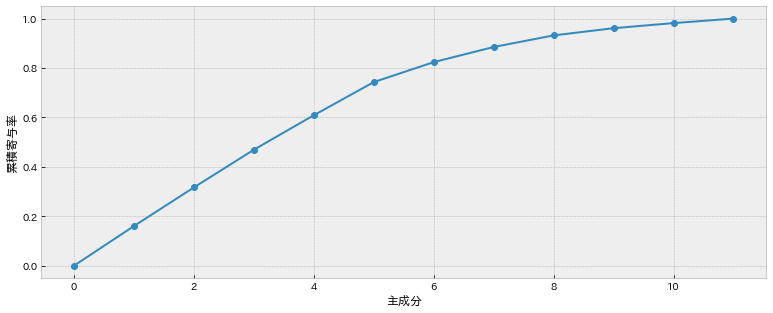

In [ ]:
# 寄与率を解釈する別の方法（図示）
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list(np.cumsum(variance_ratio,)), '-o')
plt.xlabel('主成分')
plt.ylabel('累積寄与率')
plt.show()

In [ ]:
# 主成分負荷量の確認
# 固有ベクトル
eigenvector = pca.components_

# DataFrameに格納
pd.DataFrame(eigenvector, index=[f'PC{x+1}' for x in range(len(eigenvector))], columns=x_scaled.columns)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
PC1,-0.061950,0.092221,-0.179336,0.227067,0.054113,0.046146,-0.041427,0.655628,-0.678015,0.038194,-0.078431
PC2,-0.115013,0.167175,0.681341,-0.624110,0.095454,-0.103911,0.097411,0.156436,-0.205806,0.093748,0.008377
PC3,-0.024788,0.030697,0.113863,-0.096218,0.034488,0.694988,-0.697191,-0.022275,0.006063,-0.048081,0.055693
PC4,-0.413141,0.637569,-0.011576,0.252596,0.548798,-0.016318,0.030345,-0.228761,0.025419,-0.051563,0.029646
PC5,-0.050897,-0.007518,0.014705,-0.026071,-0.090925,-0.060584,0.043448,0.072367,-0.073193,-0.693263,0.701016
PC6,0.858679,0.132653,0.060739,0.017492,0.478078,-0.018614,-0.004027,0.004128,-0.037394,-0.101957,0.018633
PC7,0.263910,0.625557,0.136949,0.176168,-0.662485,0.040029,0.024191,-0.162279,-0.123427,0.077061,0.025655
PC8,-0.031588,0.038874,0.054628,-0.052494,-0.078802,0.036352,0.043723,-0.015421,-0.003172,-0.697837,-0.703622
PC9,-0.007839,0.023265,0.029417,0.036248,-0.035101,-0.704535,-0.704591,-0.010569,-0.005688,-0.027219,-0.047781
PC10,0.030745,0.303426,-0.677740,-0.666971,-0.026976,-0.021844,-0.030648,0.019845,0.012235,0.010795,0.001316


In [ ]:
np.sqrt(pca.explained_variance_).shape

(11,)

In [ ]:
# 主成分負荷量
buy_factor_loading = pca.components_ * np.sqrt(pca.explained_variance_).reshape(11,1)

# DataFrameに格納
x_buy_factor_loading = pd.DataFrame(buy_factor_loading, index=[f'PC{x+1}' for x in range(len(factor_loading))], columns=x_buy_scaled.columns)

x_buy_factor_loading.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer
PC1,-0.082297,0.122509,-0.238237,0.301644,0.071886,0.061302,-0.055034,0.870960,-0.900699,0.050738,-0.104190
PC2,-0.150819,0.219220,0.893458,-0.818411,0.125172,-0.136262,0.127738,0.205139,-0.269879,0.122934,0.010985
PC3,-0.032114,0.039770,0.147516,-0.124656,0.044682,0.900399,-0.903253,-0.028858,0.007854,-0.062292,0.072154
PC4,-0.511856,0.789909,-0.014342,0.312951,0.679927,-0.020217,0.037595,-0.283421,0.031492,-0.063884,0.036730
PC5,-0.061825,-0.009133,0.017862,-0.031668,-0.110448,-0.073592,0.052776,0.087905,-0.088909,-0.842112,0.851530


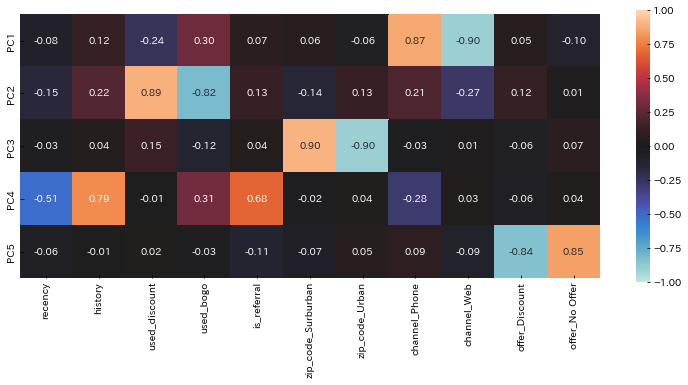

In [ ]:
# 累積寄与率より第五主成分までヒートマップで可視化
sns.heatmap(x_buy_factor_loading.head(5), vmax=1.0, center=0, vmin=-1.0, square=True, annot=True, fmt='.2f');

## サイクル1

### オファーの獲得の有無とconversionの関連 -> χ二乗検定

In [ ]:
dict_1 = {'No Offer':'No Offer', 'Buy One Get One':"Offer", 'Discount':"Offer"}
# DataFrame のコピー
df_rename = df.drop('offer', axis=1).copy()
df_rename['offer'] = df['offer'].map(dict_1)
df_rename.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,conversion,offer
0,10,142.44,1,0,Surburban,0,Phone,0,Offer
1,6,329.08,1,1,Rural,1,Web,0,No Offer
2,7,180.65,0,1,Surburban,1,Web,0,Offer


In [ ]:
crosstab = pd.crosstab(df_rename['offer'], df_rename['conversion'])
crosstab

conversion,0,1
offer,,
No Offer,19044,2262
Offer,35562,7132


In [ ]:
chi2, p, dof, ef = stats.chi2_contingency(crosstab, correction=False)
print(f'χ 二乗値:{chi2}')
print(f'p 値:{p}')
print(f'自由度:{dof}')
print(ef) # 期待度数

if p < 0.05:
    print("有意差があります")
else:
    print("有意差がありません")

χ 二乗値:420.663696307213
p 値:1.7497869967578683e-93
自由度:1
[[18178.679  3127.321]
 [36427.321  6266.679]]
有意差があります


考察：
- offrはコンバージョンと独立ではなく、影響を及ぼしている。
- offerの種類やそれを届けるチャネルがコンバージョンに影響を及ぼすかどうか分からない

## サイクル２

### offerによってCVに差があるのかどうかの検証のU検定

In [ ]:
df_used_dis = df.query('used_bogo != 1')[df['used_discount'] == 1]
df_used_bogo = df.query('used_discount != 1')[df['used_bogo'] == 1]
df_used_multi_Offer = df.query('used_bogo != 0')[df['used_discount'] == 1]

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(df_used_dis['conversion'],df_used_multi_Offer['conversion'], alternative='less')

MannwhitneyuResult(statistic=81487816.0, pvalue=6.118562729225306e-139)

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(df_used_bogo['conversion'],df_used_multi_Offer['conversion'], alternative='less')

MannwhitneyuResult(statistic=82890088.0, pvalue=4.693609150555354e-95)

- 仮説
  - 帰無仮説：2群間は独立　discountのみを使った群、bogoのみを使った群とどちらも使った群
  - 対立仮説：2群間は独立ではない
- 有意水準
 - 5%
- P値
 - 6.118562729225306e-139 < 0.05 （discountのみ利用の顧客データとの比較）
 - 4.693609150555354e-95 < 0.05 （bogoのみ利用の顧客データとの比較）
- 判定
 - 帰無仮説を棄却。2群間は独立ではない

## サイクル3


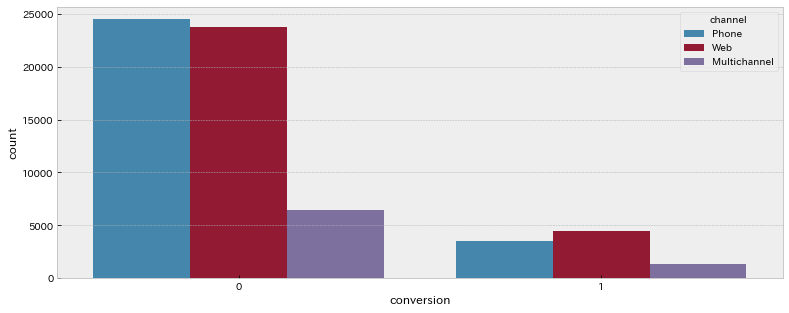

In [ ]:
sns.countplot(x='conversion', hue='channel', data=df);

In [ ]:
#コンバージョンとオファーの関係
crosstab = pd.crosstab(df['conversion'], df['channel'])
crosstab

channel,Multichannel,Phone,Web
conversion,,,
0,6429,24458,23719
1,1333,3563,4498


- 仮説
  - 帰無仮説：2群間は独立　コンバージョンと購入チャネル
  - 対立仮説：2群間は独立ではない
- 有意水準
 - 5%
- P値
 - 1.2736921440078863e-35 5％を下回る
- 判定
 - 帰無仮説を棄却。2群間は独立ではない

In [ ]:
x = pd.crosstab(df['conversion'], df['channel'])
chi2, p, dof, ef = stats.chi2_contingency(x, correction=False)
print(f'χ 二乗値:{chi2}')
print(f'p 値:{p}')
print(f'自由度:{dof}')
print(ef) # 期待度数

if p < 0.05:
    print("有意差があります")
else:
    print("有意差がありません")

χ 二乗値:160.69711674409655
p 値:1.2736921440078863e-35
自由度:2
[[ 6622.684 23908.043 24075.273]
 [ 1139.316  4112.957  4141.727]]
有意差があります


##サイクル4

In [ ]:
#コンバージョンした人を抽出
_df_not = _df.query('conversion == 0')
_df_not.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
count,54606.000000,54606.000000,54606.000000,54606.000000,54606.000000,54606.0,54606.000000,54606.000000,54606.000000,54606.000000,54606.000000,54606.000000
mean,5.872505,235.163403,0.549647,0.538988,0.517580,0.0,0.404589,0.447899,0.434366,0.318884,0.348753,0.142182
std,3.500573,251.053967,0.497534,0.498482,0.499695,0.0,0.490817,0.497283,0.495678,0.466048,0.476580,0.349240
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,62.670000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,151.835000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,315.352500,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#コンバージョンした人を抽出
_df_buy = _df.query('conversion == 1')
_df_buy.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Urban,channel_Phone,channel_Web,offer_Discount,offer_No Offer,zip_code_Rural
count,9394.000000,9394.000000,9394.000000,9394.000000,9394.000000,9394.0,9394.000000,9394.000000,9394.000000,9394.000000,9394.000000,9394.000000
mean,5.131467,282.323739,0.559080,0.612093,0.413136,1.0,0.379817,0.379285,0.478816,0.414520,0.240792,0.191505
std,3.481646,280.674183,0.496524,0.487299,0.492423,0.0,0.485367,0.485235,0.499578,0.492665,0.427587,0.393507
min,1.000000,29.990000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,80.565000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,202.460000,1.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,384.632500,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,12.000000,3215.970000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#数値化前コンバージョンしてない人を抽出
df_not_before = df.query('conversion == 0')
df_not_before.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
#数値化前コンバージョンした人を抽出
df_buy_before = df.query('conversion == 1')
df_buy_before.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
10,7,548.91,0,1,Urban,1,Phone,Buy One Get One,1
13,2,101.64,0,1,Urban,0,Web,Discount,1
15,3,58.13,1,0,Urban,1,Web,No Offer,1
22,2,118.40,1,0,Surburban,0,Web,Discount,1


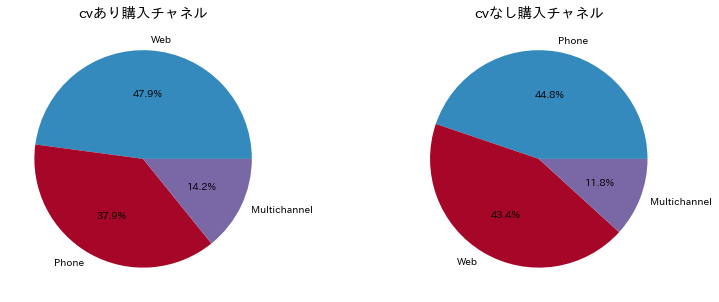

In [ ]:
#コンバージョンした人の購入チャネルを確認 2-2
plt.subplot(1, 2, 1)
channel_before = df_buy_before['channel'].value_counts()
plt.title('cvあり購入チャネル')
plt.pie(channel_before, labels=channel_before.index, autopct='%.1f%%');

plt.subplot(1, 2, 2)
channel_before = df_not_before['channel'].value_counts()
plt.title('cvなし購入チャネル')
plt.pie(channel_before, labels=channel_before.index, autopct='%.1f%%');

In [ ]:
#円グラフクロス集計ver
crosstab = pd.crosstab(df['conversion'], df['channel'])
crosstab

channel,Multichannel,Phone,Web
conversion,,,
0,6429,24458,23719
1,1333,3563,4498


### Phoneを用いる顧客とWebを用いる顧客ではコンバージョン（CV）しやすさに差はあるのか？


In [ ]:
cross_channel = pd.crosstab(df.query('channel != "Multichannel"')['channel'], df.query('channel != "Multichannel"')['conversion'])
cross_channel

conversion,0,1
channel,,
Phone,24458,3563
Web,23719,4498


In [ ]:
cross_channel_percent = pd.crosstab(df.query('channel != "Multichannel"')['channel'], df.query('channel != "Multichannel"')['conversion'], normalize='index')
cross_channel_percent

conversion,0,1
channel,,
Phone,0.872845,0.127155
Web,0.840593,0.159407


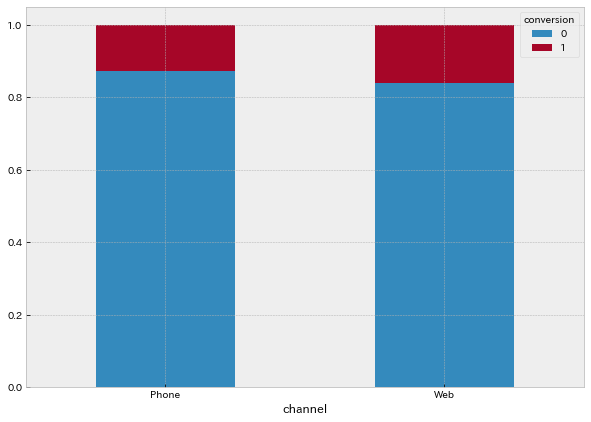

In [ ]:
plt.rcParams['figure.figsize'] = 10, 7
cross_channel_percent.plot.bar(stacked=True);
plt.xticks(rotation=0);

考察：
- 上の棒グラフはマルチチャネルが含まれていないが、Webを用いる顧客の方がPhoneを用いる顧客よりもCVする確度は高いと予想できる。
- conversion=1の確率は、その平均値の値と大きさが等しい
> 有意差かどうかを、ホイットニーのU検定の左側検定で判定する。
1. 帰無仮説：conversionの平均値は等しい
2. 対立仮説：Phoneの利用客はWebの利用客よりもconversionの平均値が小さい
3. 有意水準：5%

In [ ]:
# 数値化
_df_all = pd.get_dummies(df)

# 二つのデータフレームに分割
_df_all_Phone = _df_all[_df_all['channel_Phone'] == 1].append(_df_all[_df_all['channel_Multichannel'] == 1])
_df_all_Web = _df_all[_df_all['channel_Web'] == 1].append(_df_all[_df_all['channel_Multichannel'] == 1])

In [ ]:
# Mann-Whitney(マンホイットニー)のU検定
stats.mannwhitneyu(_df_all_Phone['conversion'], _df_all_Web['conversion'], alternative='less')

MannwhitneyuResult(statistic=627469534.0, pvalue=1.2466111827518385e-21)

> 
3. ｐ値：1.2466111827518385e-21　< 0.05
4. 判定：帰無仮説を棄却する。よって、Phoneの利用客はWebの利用客よりもconversionの平均値が小さいと言える。